# Optimize the Accuracy of Document Retrival

In this example, we build a simple workflow for solving [MATH problems](https://github.com/hendrycks/math). 

**Example Problen and Solution:**

P: The Smith family has 4 sons and 3 daughters. In how many ways can they be seated in a row of 7 chairs such that at least 2 boys are next to each other?

S: This problem is a perfect candidate for complementary counting.  It will be fairly difficult to try to count this directly, since there are lots of possible cases (just two are BBBBGGG and BGGBBGB, where B is a boy and G is a girl).  But there is only one way to assign genders to the seating so that no two boys are next to each other, and that is BGBGBGB. If we seat the children as BGBGBGB, then there are $4!$ orderings for the 4 boys, and $3!$ orderings for the 3 girls, giving a total of $4! \times 3! = 144$ seatings for the 7 children. These are the seatings that we don't want, so to count the seatings that we do want, we need to subtract these seatings from the total number of seatings without any restrictions.  Since there are 7 kids, there are $7!$ ways to seat them. So the answer is 

```math
7! - (4! \times 3!) = 5040-144 = \boxed{4896}
```


The workflow involves 2 agents:
- **Interpreter agent**: analyzes the problem and models the problem with equations.
- **Solver agent**: focuses on solving the generated model to get the answer.

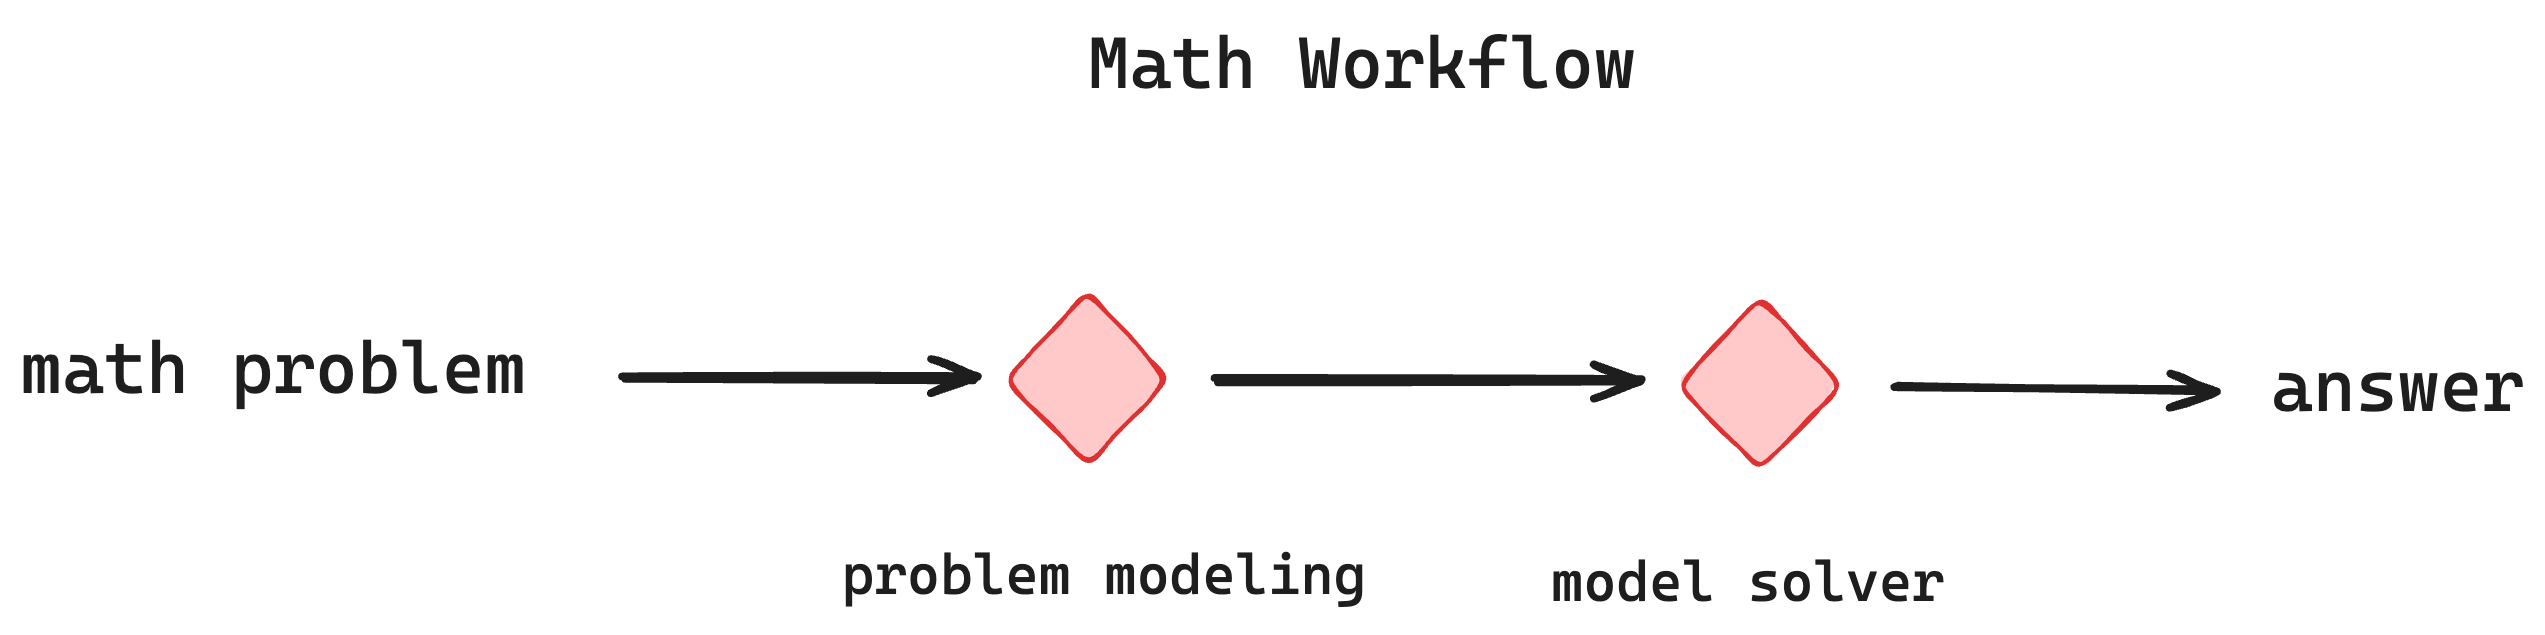

## 1) Setup

First, let's set the environment for workflow execution. We use openai model in this example, please set your key in `.env` file as:

OPENAI_API_KEY="your-openai-key"

## 2) Check Math Workflow

The implementation is based on `langchain` and is avaibale in `workflow.py`. 

Try it out with:

In [1]:
%run workflow.py

{'answer': "To solve the problem, we need to analyze the pattern of the student's actions as he opens the lockers.\n\n1. **Initial Setup**: There are 1024 lockers, all initially closed.\n\n2. **First Pass**: The student opens locker 1, then skips locker 2, opens locker 3, skips locker 4, and so on. This means he opens all odd-numbered lockers on the first pass:\n   - Opened lockers: 1, 3, 5, ..., 1023 (total of 512 lockers).\n\n3. **Turning Around**: When he reaches locker 1024, he turns around and starts back. The first closed locker he encounters is locker 2 (since all odd-numbered lockers are open). He opens locker 2, then skips locker 4, opens locker 6, skips locker 8, and continues this pattern:\n   - Opened lockers: 2, 6, 10, ..., 1022 (total of 256 lockers).\n\n4. **Subsequent Passes**: The student continues this process, alternating between opening the first closed locker he encounters and then skipping the next one. Each time he turns around, he opens lockers in a specific pat

## 3) Optimize The Workflow

The workflow entry point is already registered using annotation `cognify.register_workflow`.

Here we configure the optimization pipeline:
1. Define the evaluation method
2. Define the data loader
3. Config the optimizer

### 3.1 Use LLM-as-judge

As you can see the standard solution includes both the result and the detailed steps required to achieve it. We utilize an LLM agent to evaluate the generated output for completeness and correctness.

The agent assigns a score on a scale of 0 to 10, accounting for partially correct answers.

We implement the scoring agent with `langchain` as follows:

In [7]:
import cognify

from pydantic import BaseModel
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

# Initialize the model
import dotenv
dotenv.load_dotenv()
model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Force agent to respond with a score
from langchain.output_parsers import PydanticOutputParser
class Assessment(BaseModel):
    score: int
    
parser = PydanticOutputParser(pydantic_object=Assessment)

@cognify.register_evaluator
def llm_judge(problem, answer, solution):
    evaluator_prompt = """
You are a math problem evaluator. Your task is to grade the the answer to a math proble by assessing its correctness and completeness.

You should not solve the problem by yourself, a standard solution will be provided. 

Please rate the answer with a score between 0 and 10.
    """
    evaluator_template = ChatPromptTemplate.from_messages(
        [
            ("system", evaluator_prompt),
            ("human", "problem:\n{problem}\n\nstandard solution:\n{solution}\n\nanswer:\n{answer}\n\nYou response format:\n{format_instructions}\n"),
        ]
    )
    evaluator_agent = evaluator_template | model | parser
    assess = evaluator_agent.invoke({"problem": problem, "answer": answer, "solution": solution, "format_instructions": parser.get_format_instructions()})
    return assess.score

### 3.2 Load the Data

We provide the subsampled math data in `data._json` file for you to start with.

The data should be formatted to align with the function signature of both the workflow entry point and the evaluator.

Signatures are:
- workflow (problem) -> {'answer': ...}
- evaluator (problem, answer, solution) -> int

The workflow input expects `problem` field and will forward `answer` to the evaluator. 

Additionally, data loader needs to provide ground truth as `solution` to match the signature. 

With above rule, each data item should be formatted a tuple of (input, ground truth), each being a dictionary with required fields:

```python
(
    {'problem': ...},
    {'solution': ...}
)
```

The complete data loader code is provided below.

In [ ]:
import json
import random

@cognify.register_data_loader
def load_data():
    with open("data._json", "r") as f:
        data = json.load(f)
        
    random.seed(42)
    random.shuffle(data) 
    # format to (input, output) pairs
    new_data = []
    for d in data:
        input = {
            'problem': d["problem"],
        }
        ground_truth = {
            'solution': d["solution"],
        }
        new_data.append((input, ground_truth))
    return new_data[:30], None, new_data[30:]

### 3.3 Config the optimizer

Let's use the default configuration to optimize this workflow. The search space includes:
- 2 fewshot examples to add for each agent
- whether to apply Chain-of-thought to each agent

In [6]:
from cognify.hub.search import default

search_settings = default.create_search()

## 4 Start the Optimization

You can save the above configs in `config.py` file and use Cognify's CLI to fire the optimization with:

```console
$ cognify optimize workflow.py
```

Alternatively you can run the following:

In [ ]:
train, val, dev = load_data()

opt_cost, pareto_frontier, opt_logs = cognify.optimize(
    script_path="workflow.py",
    control_param=search_settings,
    train_set=train,
    val_set=val,
    eval_fn=llm_judge,
    force=True, # This will overwrite the existing results
)